In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Define a transform to normalize the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./cifar', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./cifar', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar/cifar-10-python.tar.gz to ./cifar
Files already downloaded and verified


In [5]:
# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)  # Input size: 32x32x3 (CIFAR-10 images)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)  # Output size: 10 classes

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

In [6]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [7]:
# Train the model
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.913
[1,  4000] loss: 1.700
[1,  6000] loss: 1.630
[1,  8000] loss: 1.586
[1, 10000] loss: 1.563
[1, 12000] loss: 1.536
[2,  2000] loss: 1.441
[2,  4000] loss: 1.431
[2,  6000] loss: 1.433
[2,  8000] loss: 1.392
[2, 10000] loss: 1.420
[2, 12000] loss: 1.410
[3,  2000] loss: 1.300
[3,  4000] loss: 1.321
[3,  6000] loss: 1.309
[3,  8000] loss: 1.309
[3, 10000] loss: 1.306
[3, 12000] loss: 1.308
[4,  2000] loss: 1.193
[4,  4000] loss: 1.232
[4,  6000] loss: 1.216
[4,  8000] loss: 1.238
[4, 10000] loss: 1.213
[4, 12000] loss: 1.225
[5,  2000] loss: 1.125
[5,  4000] loss: 1.136
[5,  6000] loss: 1.132
[5,  8000] loss: 1.119
[5, 10000] loss: 1.169
[5, 12000] loss: 1.154
[6,  2000] loss: 1.031
[6,  4000] loss: 1.052
[6,  6000] loss: 1.064
[6,  8000] loss: 1.066
[6, 10000] loss: 1.081
[6, 12000] loss: 1.112
[7,  2000] loss: 0.940
[7,  4000] loss: 0.980
[7,  6000] loss: 1.001
[7,  8000] loss: 0.993
[7, 10000] loss: 1.033
[7, 12000] loss: 1.037
[8,  2000] loss: 0.894
[8,  4000] 

In [8]:
torch.save(net.state_dict(), 'cifar_nn_model.pth')

In [9]:
# Evaluate the model on the test dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

Accuracy of the network on the 10000 test images: 53.72%


In [10]:
import cv2
import matplotlib.pyplot as plt

In [12]:
# Create an instance of 'Net' and move it to the same device as the original model
loaded_net = Net().to(device)

# Load the saved state dictionary
checkpoint = torch.load('cifar_nn_model.pth')

# Load the state dictionary into 'Net'
loaded_net.load_state_dict(checkpoint)

<All keys matched successfully>

torch.Size([1, 3, 32, 32])


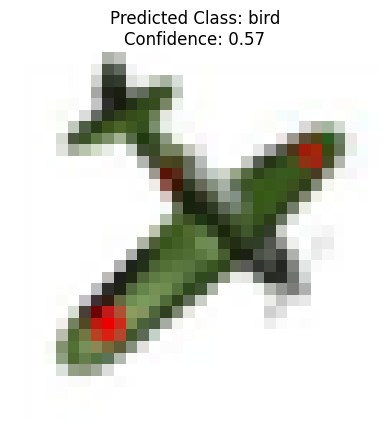

In [23]:
image = cv2.imread("./images/cifar_img1.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),  # Resize the image to match the model's input size
    transforms.ToTensor(),
])

input_image = transform(image)
input_image = input_image.unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)# Move the input to the GPU if available

with torch.no_grad():
    outputs = loaded_net(input_image)  # Unsqueeze to add batch dimension
_, predicted = torch.max(outputs, 1)

predicted_class = classes[predicted.item()]

# Get the prediction confidence
confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()

# # Show the image and prediction
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
plt.axis('off')
plt.show()

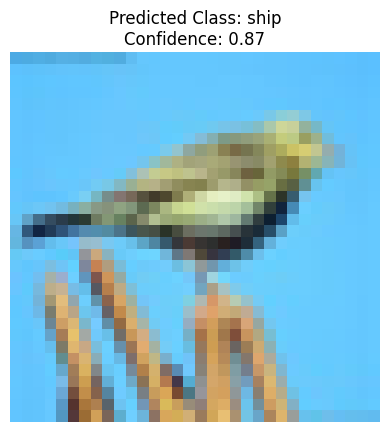

In [24]:
image = cv2.imread("./images/cifar_img2.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),  # Resize the image to match the model's input size
    transforms.ToTensor(),
])

input_image = transform(image)
input_image = input_image.unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)# Move the input to the GPU if available

with torch.no_grad():
    outputs = loaded_net(input_image)  # Unsqueeze to add batch dimension
_, predicted = torch.max(outputs, 1)

predicted_class = classes[predicted.item()]

# Get the prediction confidence
confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()

# # Show the image and prediction
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
plt.axis('off')
plt.show()

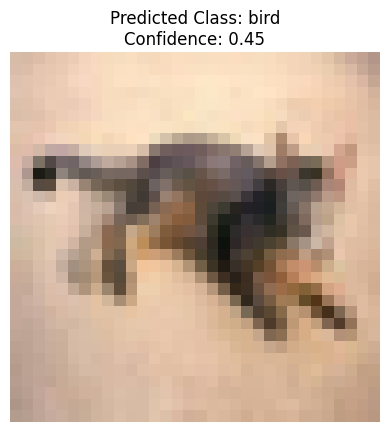

In [25]:
image = cv2.imread("./images/cifar_img3.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),  # Resize the image to match the model's input size
    transforms.ToTensor(),
])

input_image = transform(image)
input_image = input_image.unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)# Move the input to the GPU if available

with torch.no_grad():
    outputs = loaded_net(input_image)  # Unsqueeze to add batch dimension
_, predicted = torch.max(outputs, 1)

predicted_class = classes[predicted.item()]

# Get the prediction confidence
confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()

# # Show the image and prediction
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
plt.axis('off')
plt.show()